In [21]:

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [22]:
import plotly.express as px
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

In [23]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import gc

**Meteorological parameters**


dd : wind direction in degrees

ff : wind speed in m.s-1

precip : precipitation during the reporting period in kg.m2

hu : humidity in %

td : dew point temperature in Kelvin

t : temperature in Kelvin

psl : pressure reduced to sea level in Pa

In [24]:
paths = ['archive/NW_Ground_Stations/NW_Ground_Stations/NW_Ground_Stations_2017.csv',
         'archive/NW_Ground_Stations/NW_Ground_Stations/NW_Ground_Stations_2018.csv']

In [25]:
dtype = {
    'height_sta': 'int',
    'dd': 'float',  # Assuming dd is wind direction
    'ff': 'float',  # Assuming ff is wind speed
    'precip': 'float',
    'hu': 'float',  # Assuming hu is humidity
    'td': 'float',  # Assuming td is dew point temperature
    't': 'float',   # Assuming t is temperature
    'psl': 'float'  # Assuming psl is pressure at sea level
}
#reading csv
def open_csv(path:str):
    df =  pd.read_csv(
      path,
      header = 0,
      dtype = dtype
  )
    return df

In [26]:
weather_data = pd.concat((open_csv(_) for _ in paths))

#dd= wind direction and ff= wind speed,hu= Humidity, td= Dew Point temperature, 
num_cols = ['height_sta','dd', 'ff', 'precip','hu', 'td', 't', 'psl']
dtype = dict([(k,'float32') for k in num_cols])
weather_data = weather_data.loc[weather_data['lat']>48.4]
weather_data = weather_data.loc[weather_data['lon']>-1.6]
weather_data['date'] = pd.to_datetime(weather_data['date'])
values = {_:np.mean(weather_data[_]) for _ in num_cols}
weather_data = weather_data.fillna(value = values)
weather_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 13050786 entries, 0 to 22034570
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   number_sta  int64         
 1   lat         float64       
 2   lon         float64       
 3   height_sta  int64         
 4   date        datetime64[ns]
 5   dd          float64       
 6   ff          float64       
 7   precip      float64       
 8   hu          float64       
 9   td          float64       
 10  t           float64       
 11  psl         float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 1.3 GB


In [27]:
weather_data.head()

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.33,-0.43,2,2017-01-01,180.000000,1.700000,0.0,95.000000,269.550000,270.25,101688.953203
1,14126001,49.15,0.04,125,2017-01-01,188.995678,3.823897,0.0,96.000000,267.750000,268.25,101688.953203
2,14137001,49.18,-0.46,67,2017-01-01,0.000000,0.000000,0.0,98.000000,267.850000,268.15,102750.000000
3,14216001,48.93,-0.15,155,2017-01-01,210.000000,4.100000,0.0,90.000000,267.450000,268.85,101688.953203
4,14296001,48.80,-1.03,339,2017-01-01,188.995678,3.823897,0.0,80.597329,280.947985,271.05,101688.953203


In [28]:
loc = weather_data['number_sta'].sample(1).values[0]
station_id = np.unique(weather_data['number_sta'])
coordinates = [
    [
        np.mean(weather_data.loc[weather_data['number_sta'] == k,'lat']),
        np.mean(weather_data.loc[weather_data['number_sta'] == k,'lon'])
    ]
                for k in station_id
]
stations = {k:v for k,v in zip(station_id,coordinates)}

In [29]:
annual_rainfall = weather_data.groupby([weather_data['date'].dt.year,'number_sta'])['precip'].sum()
annual_rainfall = annual_rainfall.reset_index(1).groupby('number_sta')['precip'].mean()
df = pd.DataFrame(annual_rainfall)
df['lat'] = [stations[_][0] for _ in df.index]
df['lon'] = [stations[_][1] for _ in df.index]
fig = px.scatter_mapbox(
    df, lat='lat', lon='lon',
    zoom = 6,
    color = 'precip',
    color_continuous_scale=px.colors.sequential.YlGnBu
)

print('Average annual precipitation in mm')
fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker_size=12)
fig.show()

Average annual precipitation in mm


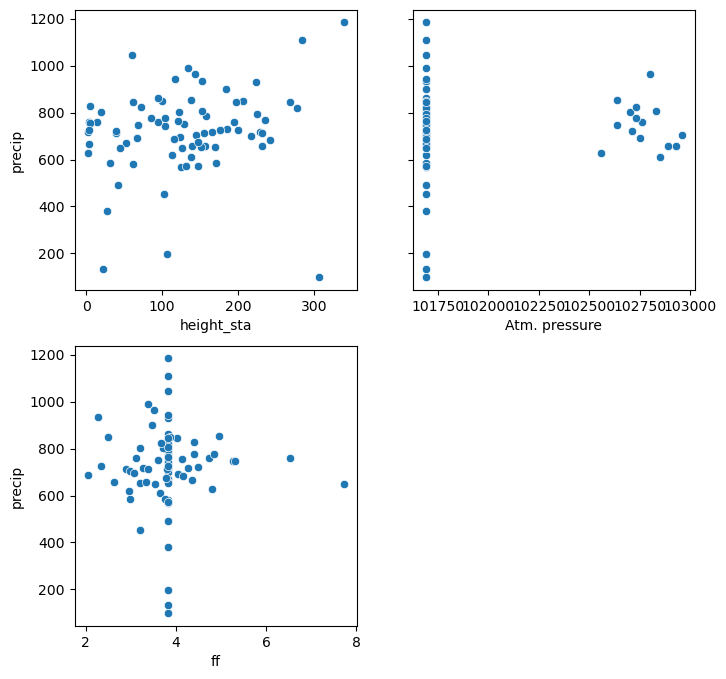

In [30]:
df = df.reset_index(0)
df['height_sta'] = [weather_data.loc[weather_data['number_sta'] == _,'height_sta'].values[0] for _ in df['number_sta']]
df['Atm. pressure'] = [weather_data.loc[weather_data['number_sta'] == _,'psl'].values[0] for _ in df['number_sta']]
df['ff'] = weather_data.groupby([weather_data['date'].dt.year,'number_sta'])['ff'].mean().groupby('number_sta').mean().values
features = ['height_sta','Atm. pressure', 'ff']

fig, axs = plt.subplots(2,2, sharey = True, figsize = [8,8])
for ax,i in zip(axs.flatten(),features) :
    sns.scatterplot(df, x = i, y = 'precip', ax = ax)
plt.delaxes(axs[1,1])

In [31]:
def color_strong_corr(val):
    color = 'red' if (abs(val) > 0.1) & (abs(val) <1.0) else 'black'
    return 'color: %s' % color
df[['precip','height_sta','Atm. pressure','ff']].corr().\
    style.applymap(color_strong_corr)

,precip,height_sta,Atm. pressure,ff
precip,1.000000,0.206452,0.064526,-0.004665
height_sta,0.206452,1.000000,-0.150925,-0.227349
Atm. pressure,0.064526,-0.150925,1.000000,0.096669
ff,-0.004665,-0.227349,0.096669,1.000000


In [36]:
df = weather_data.set_index('date')
df['t'] = df['t'] - 273.5
fig = px.line(df['2017-01-01':'2018-12-30'][['t','hu']].resample('D').mean(),
             title = 'Temperature (°C) - Humidity ratio')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [40]:
weather_data['dd'] = pd.to_numeric(weather_data['dd'], errors='coerce')
weather_data['ff'] = pd.to_numeric(weather_data['ff'], errors='coerce')
weather_data['precip'] = pd.to_numeric(weather_data['precip'], errors='coerce')
weather_data['hu'] = pd.to_numeric(weather_data['hu'], errors='coerce')
weather_data['td'] = pd.to_numeric(weather_data['td'], errors='coerce')
weather_data['t'] = pd.to_numeric(weather_data['t'], errors='coerce')
weather_data['psl'] = pd.to_numeric(weather_data['psl'], errors='coerce')

# Handling missing values - options: fillna, dropna
weather_data = weather_data.dropna(subset=['dd', 'ff', 'precip', 'hu', 'td', 't', 'psl'])

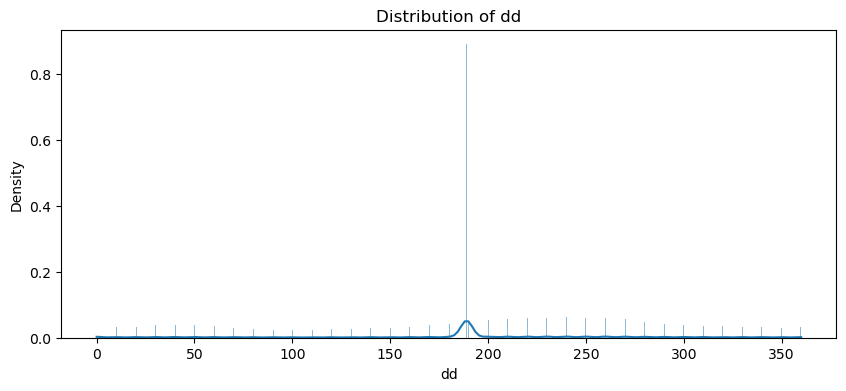

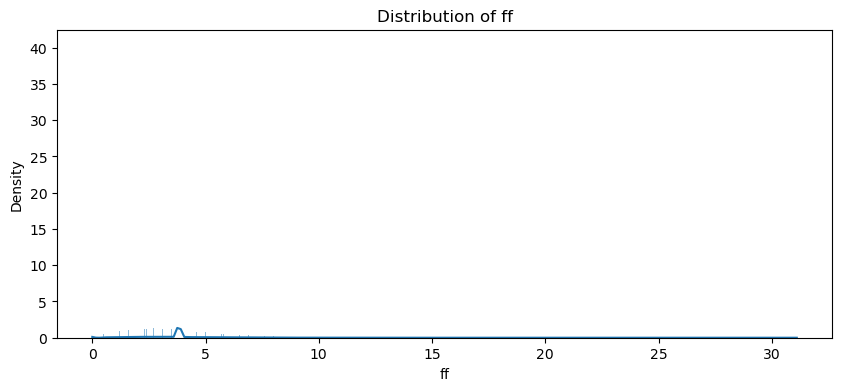

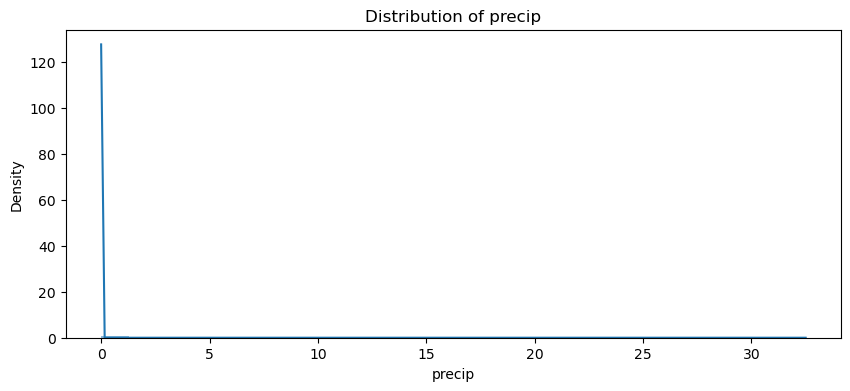

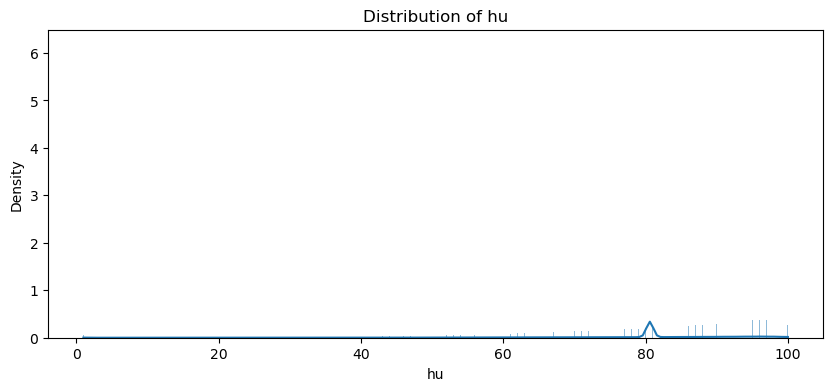

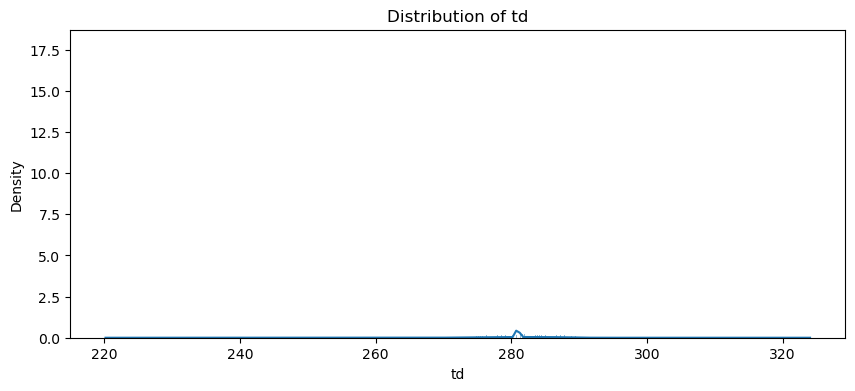

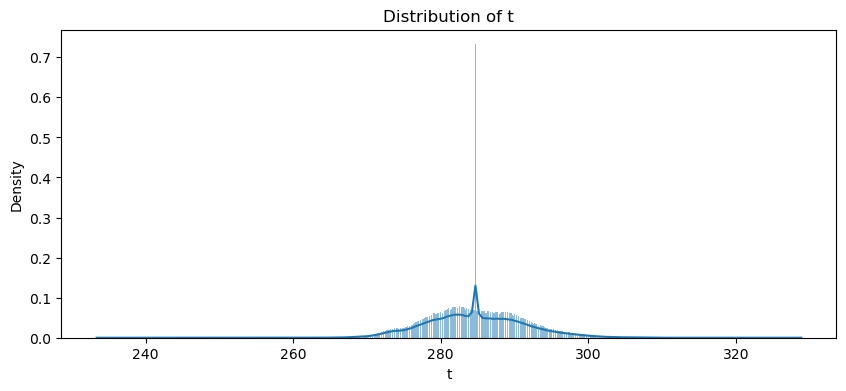

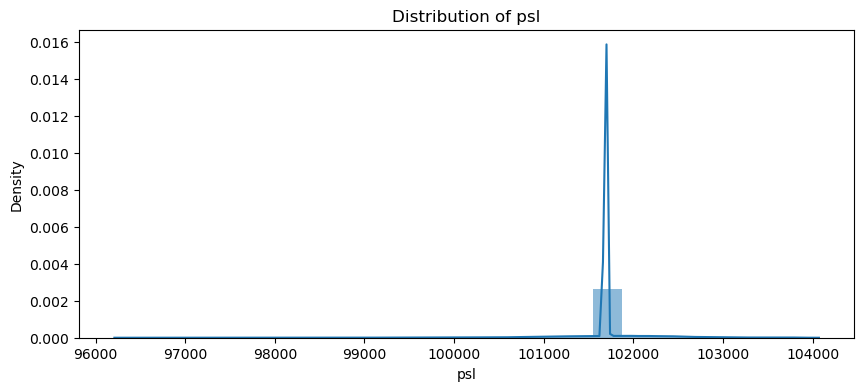

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for visual inspection of distributions
for column in ['dd', 'ff', 'precip', 'hu', 'td', 't', 'psl']:
    plt.figure(figsize=(10, 4))
    sns.histplot(weather_data[column], kde=True, stat="density", linewidth=0)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()


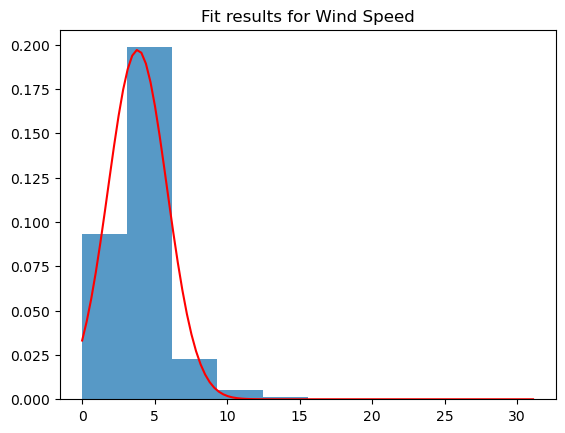

In [44]:
from scipy import stats

# Example of fitting a distribution for wind speed (ff)
param_ff = stats.norm.fit(weather_data['ff'])  # Assuming a normal distribution as a starting point
x = np.linspace(weather_data['ff'].min(), weather_data['ff'].max(), 100)
pdf_fitted = stats.norm.pdf(x, *param_ff)

plt.plot(x, pdf_fitted, 'r-')
plt.hist(weather_data['ff'], density=True, alpha=0.75)
plt.title('Fit results for Wind Speed')
plt.show()

In [45]:
# Example Kolmogorov-Smirnov test for wind speed
D, p_value = stats.kstest(weather_data['ff'], 'norm', args=param_ff)
print(f'KS statistic={D}, p-value={p_value}')


KS statistic=0.2412565036312761, p-value=0.0


In [51]:

# Initialize an empty DataFrame to store summary data
summary_table = pd.DataFrame(columns=['Variable', 'Distribution', 'Parameters'])

# List of columns for which to fit distributions
columns = ['dd', 'ff', 'precip', 'hu', 'td', 't', 'psl']

# Loop through each variable
for column in columns:
    # Fitting a normal distribution to each variable
    params = stats.norm.fit(weather_data[column])
    # Creating a temporary DataFrame to hold the fit parameters for the current variable
    temp_df = pd.DataFrame({
        'Variable': [column],
        'Distribution': ['Normal'],
        'Parameters': [f'Mean={params[0]:.2f}, SD={params[1]:.2f}']
    })
    # Concatenate the temporary DataFrame to the main summary table
    summary_table = pd.concat([summary_table, temp_df], ignore_index=True)

# Display the summary table
print(summary_table)

  Variable Distribution                 Parameters
0       dd       Normal      Mean=189.00, SD=80.89
1       ff       Normal         Mean=3.82, SD=2.03
2   precip       Normal         Mean=0.01, SD=0.08
3       hu       Normal       Mean=80.60, SD=12.61
4       td       Normal       Mean=280.95, SD=5.09
5        t       Normal       Mean=284.69, SD=6.57
6      psl       Normal  Mean=101688.95, SD=415.82
